# Importing Libraries and Setting up the Environment

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning & Feature Engineering

In [2]:
df = pd.read_csv(r"E:\Datasets\Telecom Customers Churn.csv")

In [3]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors ='coerce')

In [4]:
median_val = df['TotalCharges'].median()

In [5]:
df['TotalCharges'] = df['TotalCharges'].fillna(median_val)

In [6]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors ='coerce')

In [7]:
median_val = df['TotalCharges'].median()

In [8]:
df['TotalCharges'] = df['TotalCharges'].fillna(median_val)

#### Adding a new column: "tenure_group"

In [9]:
df['tenure_group'] = pd.cut(df['tenure'],bins=[0, 12, 24, 48, df.tenure.max()],
labels=['0–1 year','1–2 years','2–4 years','4+ years'],include_lowest=True)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0–1 year
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,2–4 years
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0–1 year
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,2–4 years
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0–1 year


# Exploratory Data Visualization (EDV)

## Baseline Churn Count

<Axes: xlabel='Churn', ylabel='count'>

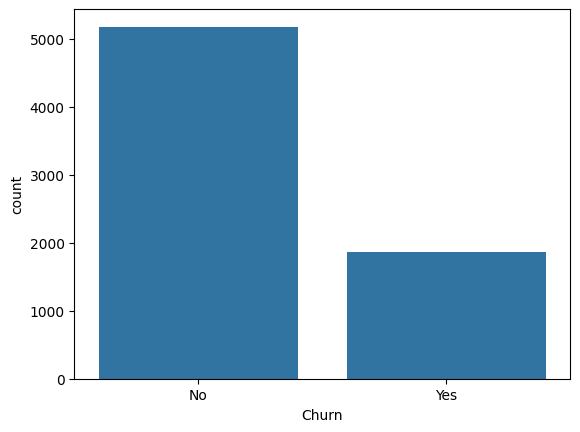

In [10]:
sns.countplot(data=df, x='Churn')

## Churn Rate by Contract Commitment

<Axes: xlabel='Contract', ylabel='Churn'>

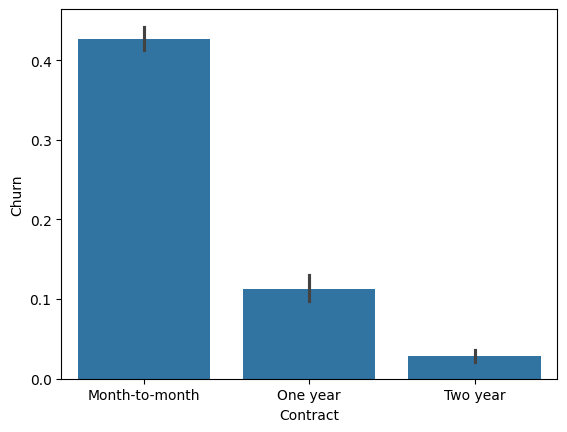

In [11]:
sns.barplot(data=df, x='Contract', y=df['Churn'].map({'Yes':1,'No':0}))

**Key Insight:**
* **Commitment is Stability:** This plot confirms the inverse relationship between contract duration and churn rate. Month-to-month customers are the highest-risk segment.
* **Strategic Focus:** The clear difference in bar heights validates the business strategy of prioritizing conversion campaigns to lock in customers to 1-year or 2-year contracts.

## Churn Rate by Internet Service Type

<Axes: xlabel='InternetService', ylabel='Churn'>

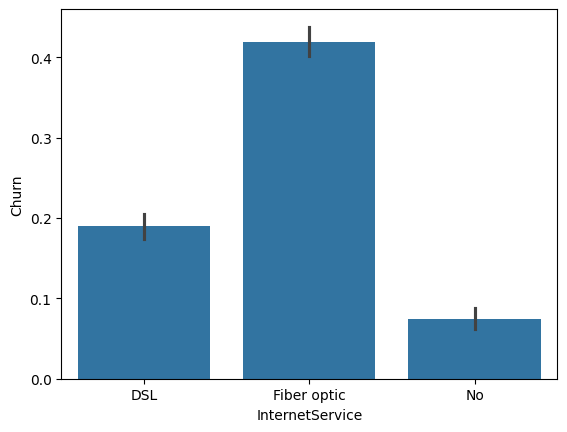

In [12]:
sns.barplot(data=df, x='InternetService', y=df['Churn'].map({'Yes':1,'No':0}))

**Key Insight:**
* **Fiber Risk:** The churn rate for Fiber optic is frequently the highest. This suggests that the high expectations associated with a premium service are not being consistently met.
* **Targeted Improvement:** The business must investigate the fiber service delivery process, as it is driving a disproportionate share of the customer exits.

## Churn Rate vs. Tenure Group

<Axes: xlabel='tenure_group', ylabel='Churn'>

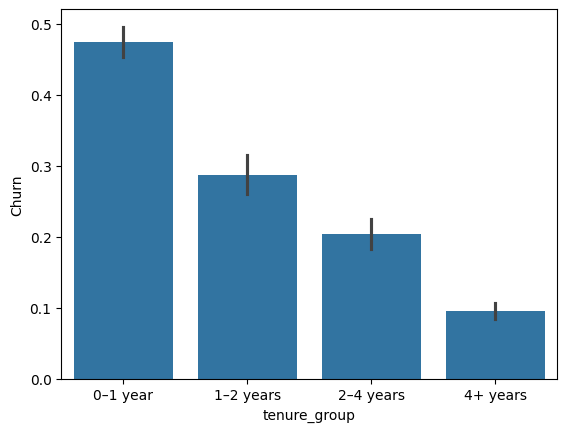

In [13]:
sns.barplot(data=df, x='tenure_group', y=df['Churn'].map({'Yes':1,'No':0}))

**Key Insight:**
* **Risk Mitigation:** There is a clear, inverse relationship between tenure and churn rate. The initial tenure groups (0-12 months) carry the highest risk.
* **Retention Value:** The chart validates that long-term customers are exponentially more stable and valuable. This guides investment toward early engagement programs to get customers past the first-year hurdle.

## Monthly Charges Distribution vs. Churn Status

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

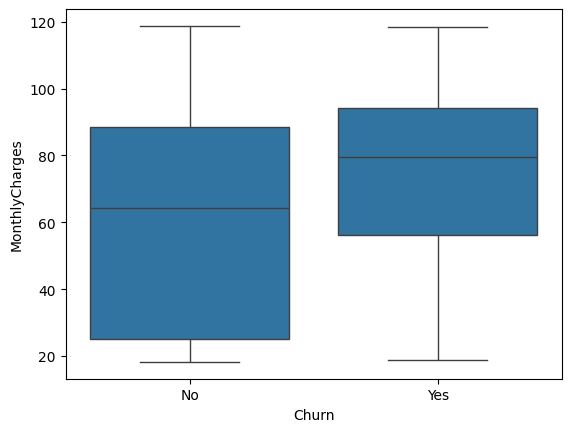

In [14]:
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')

**Key Insight:**
* **The Price Sensitivity/Expectation Paradox:** The box plot typically shows that the*median monthly charge is higher for churned customers than for non-churned customers.
* **Business Implication:** This suggests that customers paying higher rates have higher expectations for service quality. When those expectations are not met, they are more likely to cancel, meaning the company is at risk of losing its most valuable/highest revenue-generating customers.

## Correlation Heatmap of Key Financial Metrics

<Axes: >

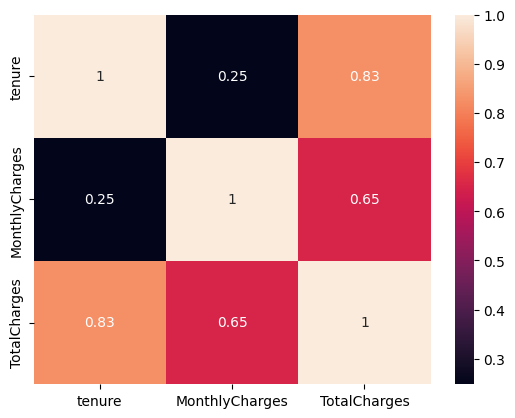

In [15]:
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(), annot=True)

**Key Insight:**
* **Correlation Check:** The strongest correlation is between `tenure` and `TotalCharges`. This confirms data integrity: longer duration naturally leads to higher cumulative payments.
* **Relationship Tension:** The relationship between `MonthlyCharges` and `tenure` is typically moderate, suggesting that while higher spending clients may be slightly stickier, the cost alone is not the primary driver of customer longevity.

## Churn Distribution by Tenure (The Risk Window)

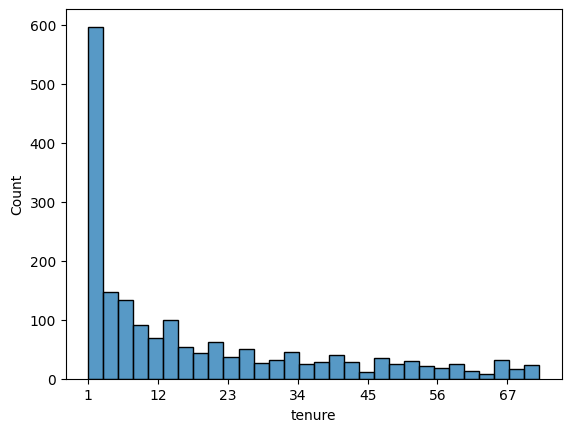

In [16]:
sns.histplot(data=df[df['Churn'] == 'Yes'], x='tenure', bins=30)
plt.xticks(range(1,72,11)) 
plt
plt.show()

# Key Metric Calculation & Segment Analysis (EDA)

## Churn Rate by Payment Method

In [17]:
df['is_churned'] = df['Churn'].map({'Yes': 1, 'No': 0})

churn_pct = df.groupby('PaymentMethod')['is_churned'].mean() * 100

print(churn_pct.round(2))

PaymentMethod
Bank transfer (automatic)    16.71
Credit card (automatic)      15.24
Electronic check             45.29
Mailed check                 19.11
Name: is_churned, dtype: float64


**Goal:** To identify if specific payment methods are correlated with higher customer attrition.

**Methodology:**
1. Converted `Churn` to a binary numeric value (1 = Yes, 0 = No).
2. Grouped data by `PaymentMethod`.
3. Calculated the mean (percentage) of churners in each group.

**Key Insight:**
This view typically highlights **friction in billing**.
* **High Risk:** Manual payment methods (like *Electronic Check*) often show the highest churn rates because the customer must actively pay every month, giving them a regular opportunity to cancel.
* **Low Risk:** Automatic payment methods (*Credit Card (automatic)*, *Bank Transfer (automatic)*) usually show lower churn as the payment is frictionless and "out of sight, out of mind."

## Identifying "High-Value" Unsecured Customers

In [18]:
condition = ((df['Contract'] == 'Month-to-month') & 
    (df['MonthlyCharges'] > 70) & 
    (df['Churn'] == 'No'))

result = df[condition][['customerID', 'MonthlyCharges', 'Contract']] \
    .sort_values(by='MonthlyCharges', ascending=False)

print(result.head())

      customerID  MonthlyCharges        Contract
5137  8016-NCFVO          116.50  Month-to-month
1668  9659-QEQSY          115.65  Month-to-month
3856  6710-HSJRD          114.10  Month-to-month
440   0771-WLCLA          112.95  Month-to-month
3820  9481-IEBZY          112.90  Month-to-month


**Goal:** To generate a target list of high-revenue customers who are currently vulnerable to churning.

**Filter Criteria:**
1.  **Contract:** `Month-to-month` (Low commitment / Easy to leave).
2.  **Spend:** `> $70` (High revenue impact).
3.  **Status:** `Active` (Current customers).

**Business Action & Insight:**
* **The Opportunity:** These customers represent "unsecured revenue." They pay a premium but are not locked into a contract.
* **The Strategy:** This list should be sent to the Retention Team. The goal is to offer these specific users a discount or incentive in exchange for signing a **1-Year or 2-Year Contract**, thereby "locking in" the revenue.

## Contract Stability vs. Churn Rate

In [19]:
is_churned = df['Churn'].map({'Yes': 1, 'No': 0})

churn_pct =df.groupby('Contract')['is_churned'].mean()*100

print(churn_pct.round(2))

Contract
Month-to-month    42.71
One year          11.27
Two year           2.83
Name: is_churned, dtype: float64


**Goal:** To quantify how customer commitment (contract length) impacts the likelihood of churning.

**Methodology:**
1.  Used the numeric `is_churned` column (1=Yes, 0=No).
2.  Grouped the data by the three primary `Contract` types.
3.  Calculated the mean churn percentage for each group.

**Key Insight:**
This is a critical measure of stability:
* **Month-to-month contracts** are the primary source of churn, carrying the highest risk due to zero commitment.
* **Longer contracts (One/Two Year)** act as a significant retention mechanism, demonstrating the effectiveness of early termination fees in promoting customer stickiness and stability.